In [9]:
import cv2
import mediapipe as mp
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, TimeDistributed, Flatten
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
# Initialize Mediapipe Face Mesh model
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Function to detect and crop the mouth region from an image
def detect_and_crop_mouth(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mouth_indices = [
                61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 308,
                324, 318, 402, 317, 14, 87, 178, 88, 95
            ]
            
            mouth_points = [(int(face_landmarks.landmark[i].x * image.shape[1]),
                             int(face_landmarks.landmark[i].y * image.shape[0])) for i in mouth_indices]
            
            x_min = min([point[0] for point in mouth_points])
            x_max = max([point[0] for point in mouth_points])
            y_min = min([point[1] for point in mouth_points])
            y_max = max([point[1] for point in mouth_points])
            
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(image.shape[1], x_max)
            y_max = min(image.shape[0], y_max)
            
            cropped_mouth = image[y_min:y_max, x_min:x_max]
            
            if cropped_mouth.size == 0:
                return None
            return cropped_mouth
    return None

In [11]:
# Augmentation Functions for mouth region
def augment_mouth(cropped_mouth):
    if np.random.rand() > 0.5:
        cropped_mouth = cv2.flip(cropped_mouth, 1)

    angle = np.random.randint(-30, 30)
    M = cv2.getRotationMatrix2D((cropped_mouth.shape[1] // 2, cropped_mouth.shape[0] // 2), angle, 1)
    cropped_mouth = cv2.warpAffine(cropped_mouth, M, (cropped_mouth.shape[1], cropped_mouth.shape[0]))

    scale_factor = np.random.uniform(0.8, 1.2)
    new_width = int(cropped_mouth.shape[1] * scale_factor)
    new_height = int(cropped_mouth.shape[0] * scale_factor)
    cropped_mouth = cv2.resize(cropped_mouth, (new_width, new_height))

    return cropped_mouth

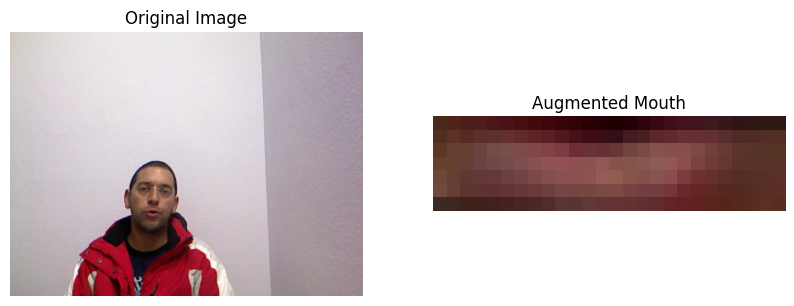

In [18]:
# Visualization function to display an augmented mouth detection example
def visualize_mouth_detection(image_path):
    image = cv2.imread(image_path)
    cropped_mouth = detect_and_crop_mouth(image)
    
    if cropped_mouth is not None:
        augmented_mouth = augment_mouth(cropped_mouth)
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Original Image")
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(augmented_mouth, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Augmented Mouth")
        
        plt.show()
    else:
        print("Mouth not detected in the image.")

# Test the function on an example image
visualize_mouth_detection("C:\\Users\\la7tim\\Downloads\\MIRACL-VC1_all_in_one\\M07\\phrases\\09\\10\\color_010.jpg")

In [12]:
# Preprocess the cropped mouth image
def preprocess_mouth_image(cropped_mouth, output_size=(64, 64)):
    if cropped_mouth is not None:
        resized_image = cv2.resize(cropped_mouth, output_size)
        grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        normalized_image = grayscale_image / 255.0
        return normalized_image
    return None

In [20]:
def create_augmented_dataset(root_folder, word_labels, phrase_labels, output_size=(64, 64), augment=False):
    X, y = [], []

    word_labels = {f"{int(k):02}": v for k, v in word_labels.items()}
    phrase_labels = {f"{int(k):02}": v for k, v in phrase_labels.items()}

    for person_id in os.listdir(root_folder):
        person_path = os.path.join(root_folder, person_id)
        if os.path.isdir(person_path):
            for data_type in ["words", "phrases"]:
                type_path = os.path.join(person_path, data_type)
                labels_dict = word_labels if data_type == "words" else phrase_labels
                
                if os.path.isdir(type_path):
                    for label_id in os.listdir(type_path):
                        label_path = os.path.join(type_path, label_id)
                        if os.path.isdir(label_path):
                            for instance_id in os.listdir(label_path):
                                instance_path = os.path.join(label_path, instance_id)
                                sequence = []

                                for file in sorted(os.listdir(instance_path)):
                                    if file.endswith(".jpg"):
                                        file_path = os.path.join(instance_path, file)
                                        image = cv2.imread(file_path)
                                        if image is not None:
                                            cropped_mouth = detect_and_crop_mouth(image)
                                            
                                            if cropped_mouth is not None:  # Check if mouth was successfully detected
                                                if augment:
                                                    cropped_mouth = augment_mouth(cropped_mouth)  # Apply augmentation
                                                preprocessed_image = preprocess_mouth_image(cropped_mouth, output_size)
                                                if preprocessed_image is not None:
                                                    sequence.append(preprocessed_image)
                                                
                                if sequence:
                                    if label_id in labels_dict:
                                        X.append(sequence)
                                        y.append(labels_dict[label_id])
                                    else:
                                        print(f"Warning: No label found for label ID: {label_id}. Skipping.")
    return np.array(X, dtype=object), np.array(y)


In [24]:
# Word and Phrase Mappings
WORD_LABELS = {
    1: "Begin",
    2: "Choose",
    3: "Connection",
    4: "Navigation",
    5: "Next",
    6: "Previous",
    7: "Start",
    8: "Stop",
    9: "Hello",
    10: "Well"
}

PHRASE_LABELS = {
    1: "Stop navigation.",
    2: "Excuse me.",
    3: "I am sorry.",
    4: "Thank you.",
    5: "Good bye.",
    6: "I love this game.",
    7: "Nice to meet you.",
    8: "You are welcome.",
    9: "How are you?",
    10: "Have a good time."
}


In [83]:
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, LSTM, Flatten, BatchNormalization, Dropout, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

def build_vgg_feature_extractor(input_shape=(64, 64, 3)):
    """Build the VGG feature extractor (VGG16 in this case)"""
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)  # Input shape for RGB images
    return vgg

def build_recurrent_model(input_shape, num_classes):
    vgg_feature_extractor = build_vgg_feature_extractor()
    
    model = tf.keras.Sequential([
        TimeDistributed(vgg_feature_extractor, input_shape=input_shape),
        TimeDistributed(Flatten()),  # Flatten the output of VGG for each time step
        LSTM(128, return_sequences=True),  # LSTM to capture temporal dependencies
        BatchNormalization(),  # Normalize output for stable training
        Dropout(0.2),  # Dropout regularization
        LSTM(128),  # Second LSTM layer
        Dense(128, activation='relu'),  # Fully connected layer
        Dense(num_classes, activation='softmax')  # Output layer for classification
    ])
    
    return model

def preprocess_labels(y_train, y_val):
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_val = label_encoder.transform(y_val)
    return y_train, y_val

def preprocess_sequences(X_train, X_val, target_sequence_length):
    X_train = pad_sequences(X_train, maxlen=target_sequence_length, padding='post', truncating='post')
    X_val = pad_sequences(X_val, maxlen=target_sequence_length, padding='post', truncating='post')

    # Convert grayscale images to RGB by duplicating the channels
    X_train = np.repeat(X_train[..., np.newaxis], 3, -1)  # Repeat to make it (64, 64, 3)
    X_val = np.repeat(X_val[..., np.newaxis], 3, -1)
    
    return X_train, X_val

def train_model(X_train, y_train, X_val, y_val, num_classes, batch_size=32, epochs=50):
    y_train, y_val = preprocess_labels(y_train, y_val)
    
    target_sequence_length = 10  # Target sequence length is 10
    X_train, X_val = preprocess_sequences(X_train, X_val, target_sequence_length)

    # Debug: print the shape of X_train to understand its current structure
    print(f"X_train shape before reshaping: {X_train.shape}")

    # Ensure correct shape for sequences (10 images per sequence)
    try:
        X_train = np.reshape(X_train, (X_train.shape[0], target_sequence_length, 64, 64, 3))  # 10 images per sequence and 64x64 RGB images
        X_val = np.reshape(X_val, (X_val.shape[0], target_sequence_length, 64, 64, 3))
    except ValueError as e:
        print("Error reshaping X_train and X_val:", e)
        print("X_train shape:", X_train.shape)
        print("X_val shape:", X_val.shape)
        return None, None

    # Get the input shape dynamically based on reshaped data
    image_shape = X_train[0][0].shape  # Shape of the first image in the sequence
    input_shape = (target_sequence_length, image_shape[0], image_shape[1], 3)  # RGB images
    
    model = build_recurrent_model(input_shape, num_classes)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        batch_size=batch_size, epochs=epochs)
    
    return model, history


# Assume create_augmented_dataset is defined elsewhere
X, y = create_augmented_dataset(
    root_folder="C:\\Users\\la7tim\\Downloads\\MIRACL-VC1_all_in_one", 
    word_labels=WORD_LABELS, 
    phrase_labels=PHRASE_LABELS,
    augment=True
)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
num_classes = len(np.unique(y_train))  # Set num_classes dynamically based on the unique labels in y_train


model, history = train_model(X_train, y_train, X_val, y_val, num_classes=num_classes)


X_train shape before reshaping: (2400, 10, 64, 64, 3)


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 360s 5s/step - accuracy: 0.0357 - loss: 3.0080 - val_accuracy: 0.0500 - val_loss: 3.0028
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 381s 5s/step - accuracy: 0.0472 - loss: 2.9965 - val_accuracy: 0.0383 - val_loss: 3.0051
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 366s 5s/step - accuracy: 0.0465 - loss: 2.9988 - val_accuracy: 0.0483 - val_loss: 2.9987
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 369s 5s/step - accuracy: 0.0605 - loss: 2.9961 - val_accuracy: 0.0383 - val_loss: 3.0015
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 352s 5s/step - accuracy: 0.0419 - loss: 2.9966 - val_accuracy: 0.0383 - val_loss: 2.9983
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 344s 5s/step - accuracy: 0.0451 - loss: 2.9974 - val_accuracy: 0.0383 - val_loss: 3.0011
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 344s 5s/step - accuracy: 0.0529 - loss: 2.9976 - val_accuracy: 0.0383 - val_loss: 2.9992
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 338s 5s/step - accuracy: 0.0474 - loss: 2.9951 - val_accuracy: 0.0533 - v

In [81]:
print(f"Unique labels in y_train: {np.unique(y_train)}")
print(f"Number of classes: {num_classes}")


Unique labels in y_train: ['Begin' 'Choose' 'Connection' 'Excuse me.' 'Good bye.'
 'Have a good time.' 'Hello' 'How are you?' 'I am sorry.'
 'I love this game.' 'Navigation' 'Next' 'Nice to meet you.' 'Previous'
 'Start' 'Stop' 'Stop navigation.' 'Thank you.' 'Well' 'You are welcome.']
Number of classes: 10


In [82]:
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_val:", np.unique(y_val))


Unique labels in y_train: ['Begin' 'Choose' 'Connection' 'Excuse me.' 'Good bye.'
 'Have a good time.' 'Hello' 'How are you?' 'I am sorry.'
 'I love this game.' 'Navigation' 'Next' 'Nice to meet you.' 'Previous'
 'Start' 'Stop' 'Stop navigation.' 'Thank you.' 'Well' 'You are welcome.']
Unique labels in y_val: ['Begin' 'Choose' 'Connection' 'Excuse me.' 'Good bye.'
 'Have a good time.' 'Hello' 'How are you?' 'I am sorry.'
 'I love this game.' 'Navigation' 'Next' 'Nice to meet you.' 'Previous'
 'Start' 'Stop' 'Stop navigation.' 'Thank you.' 'Well' 'You are welcome.']


In [87]:
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, BatchNormalization, Dropout, Dense, GlobalAveragePooling3D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

def build_3d_cnn_model(input_shape, num_classes):
    """Build a 3D CNN model for spatiotemporal feature extraction and classification."""
    model = tf.keras.Sequential([
        # 3D Convolutional Layers
        Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Dropout(0.3),
        
        Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Dropout(0.3),
        
        # Apply GlobalAveragePooling3D earlier
        GlobalAveragePooling3D(),
        
        # Fully Connected Layers
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')  # Output layer for classification
    ])
    
    return model



def preprocess_labels(y_train, y_val):
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_val = label_encoder.transform(y_val)
    return y_train, y_val

def preprocess_sequences(X_train, X_val, target_sequence_length):
    X_train = pad_sequences(X_train, maxlen=target_sequence_length, padding='post', truncating='post')
    X_val = pad_sequences(X_val, maxlen=target_sequence_length, padding='post', truncating='post')

    # Convert grayscale images to RGB by duplicating the channels
    X_train = np.repeat(X_train[..., np.newaxis], 3, -1)  # Repeat to make it (64, 64, 3)
    X_val = np.repeat(X_val[..., np.newaxis], 3, -1)
    
    return X_train, X_val

def train_model(X_train, y_train, X_val, y_val, num_classes, batch_size=32, epochs=50):
    y_train, y_val = preprocess_labels(y_train, y_val)
    
    target_sequence_length = 10  # Target sequence length is 10
    X_train, X_val = preprocess_sequences(X_train, X_val, target_sequence_length)

    # Debug: print the shape of X_train to understand its current structure
    print(f"X_train shape before reshaping: {X_train.shape}")

    # Ensure correct shape for sequences (10 images per sequence)
    try:
        X_train = np.reshape(X_train, (X_train.shape[0], target_sequence_length, 64, 64, 3))  # 10 images per sequence and 64x64 RGB images
        X_val = np.reshape(X_val, (X_val.shape[0], target_sequence_length, 64, 64, 3))
    except ValueError as e:
        print("Error reshaping X_train and X_val:", e)
        print("X_train shape:", X_train.shape)
        print("X_val shape:", X_val.shape)
        return None, None

    # Get the input shape dynamically based on reshaped data
    image_shape = X_train[0].shape  # Shape of a sequence (time steps, height, width, channels)
    input_shape = image_shape
    
    model = build_3d_cnn_model(input_shape, num_classes)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        batch_size=batch_size, epochs=epochs)
    
    return model, history


# Assume create_augmented_dataset is defined elsewhere
X, y = create_augmented_dataset(
    root_folder="C:\\Users\\la7tim\\Downloads\\MIRACL-VC1_all_in_one", 
    word_labels=WORD_LABELS, 
    phrase_labels=PHRASE_LABELS,
    augment=True
)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
num_classes = len(np.unique(y_train))  # Set num_classes dynamically based on the unique labels in y_train

model, history = train_model(X_train, y_train, X_val, y_val, num_classes=num_classes)


X_train shape before reshaping: (2400, 10, 64, 64, 3)


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 544ms/step - accuracy: 0.0470 - loss: 2.9959 - val_accuracy: 0.0383 - val_loss: 2.9963
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 530ms/step - accuracy: 0.0521 - loss: 2.9956 - val_accuracy: 0.0383 - val_loss: 2.9970
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 533ms/step - accuracy: 0.0472 - loss: 2.9957 - val_accuracy: 0.0383 - val_loss: 2.9974
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 531ms/step - accuracy: 0.0592 - loss: 2.9953 - val_accuracy: 0.0383 - val_loss: 2.9979
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 532ms/step - accuracy: 0.0480 - loss: 2.9954 - val_accuracy: 0.0383 - val_loss: 2.9983
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 529ms/step - accuracy: 0.0530 - loss: 2.9953 - val_accuracy: 0.0383 - val_loss: 2.9986
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 534ms/step - accuracy: 0.0521 - loss: 2.9957 - val_accuracy: 0.0383 - val_loss: 2.9992
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 529ms/step - accuracy: 0.0526 - loss: 2.9946 - val_accu